# Automatic generation of image-captions

![alt text](model.png)

- Today's tutorial aims at showing you the capabilities that neural networks have when dealing with images and language. 
- We will see how to use some pre-trained neural networks to program our image-caption generator: we will create a simple system which given any image as input, will output a brief description of the image. 
- This system will consist of two neural networks, the first one will be responsible for dealing with the visual part of the problem (called the encoder), while the second one with the linguistic one (called the decoder). 
- A part of your work is also to deal with any missing library, using `conda install` or `pip install` whatever is missing

We will **not train these neural networks ourselves**, therefore you will need to have downloaded the following files: 

- `encoder.pkl` : a pickle file containing the weights of the encoder
- `encoder.pkl` : a pickle file containing the weights of the decoder
- `vocabulary.pkl` : a pickle file containing the vocabulary used
 


In [7]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms
import torchvision.models as models
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load an image we want to generate a caption for

- Write a custom function which given a path to an image loads it with the PIL library (see imports above and https://he-arc.github.io/livre-python/pillow/index.html)
- The image should be resized to a 224x224 pixels image
- Explore the type of the object which gets loaded, do you think it is possible to use such an object as input to a neural network? Why/Why not?

In [9]:
# Your code goes here
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    return image

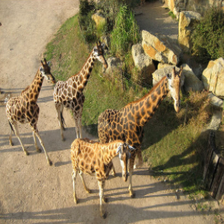

In [10]:
image_path = "giraffe.png"
image = load_image(image_path)
image

In [11]:
type(image)

PIL.Image.Image

## Convert the loaded image to a tensor

An `Image` object cannot be used as input for a neural network. We need in fact to convert it to a tensor and normalize the values of its pixels

- Write a custom function that gets a PIL Image as input, normalizes its pixels and converts the image to a tensor which can be used as input for a neural network. For this, use the `torchvision` library, in particular its `transforms` module, and the `Compose`, `ToTensor` and `Normalize` classes, among others. 
- **Warning**: You should use `ImageNet`'s means and standard deviations to normalize each channel, look what this means and code it!
- The size of the output tensor should be `(1, 3, 244, 244)`

In [12]:
# Your code goes here
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))
    ])
    image_tensor = transform(image).unsqueeze(0)
    image_tensor = image_tensor.to(device)
    return image_tensor

In [13]:
image_tensor = preprocess_image(image)

In [14]:
image_tensor.size()

torch.Size([1, 3, 224, 224])

In [15]:
image_tensor.dtype

torch.float32

In [16]:
print(type(image_tensor))

<class 'torch.Tensor'>


## Load the vocabulary of words which will be used for creating a caption

The neural network will require a pool of words to choose from to come up with an appropriate caption for an image. 

- Write a function that loads the pickle file and returns the "vocabulary" object
- Look at the attributes contained in this "vocabulary". What are those ? What do they do ?

In [17]:
# Your code goes here
def load_vocabulary(vocab_path):
    with open(vocab_path, 'rb') as f:
        vocab = pickle.load(f)
        
    return vocab

In [18]:
vocab_path = "vocabulary.pkl"
vocab = load_vocabulary(vocab_path)

In [19]:
vocab

{'idx2word': {0: '<pad>',
  1: '<start>',
  2: '<end>',
  3: '<unk>',
  4: 'woods',
  5: 'hanging',
  6: 'woody',
  7: 'comically',
  8: 'canes',
  9: 'bringing',
  10: 'wooded',
  11: 'broiler',
  12: 'wooden',
  13: 'broiled',
  14: 'crotch',
  15: 'snuggles',
  16: 'bannister',
  17: 'snuggled',
  18: 'cooking',
  19: 'numeral',
  20: 'crouch',
  21: 'china',
  22: 'kids',
  23: 'talbe',
  24: 'climber',
  25: 'golden',
  26: 'projection',
  27: 'stern',
  28: 'music',
  29: 'locked',
  30: 'locker',
  31: 'wand',
  32: 'want',
  33: 'cookers',
  34: 'pinto',
  35: 'travel',
  36: 'barstools',
  37: 'over-sized',
  38: 'dinosaurs',
  39: 'modest',
  40: 'domed',
  41: 'colorfully',
  42: 'concoction',
  43: 'fir',
  44: 'fit',
  45: 'fix',
  46: 'bulding',
  47: 'mountainside',
  48: 'effects',
  49: 'sixteen',
  50: 'undeveloped',
  51: 'arrow',
  52: 'windmill',
  53: 'telescope',
  54: 'grapefruits',
  55: 'smirk',
  56: 'mason',
  57: 'pumpkins',
  58: 'bannanas',
  59: 'kfc',
 

In [20]:
len(vocab["idx2word"])

9956

In [21]:
{k: v for i, (k, v) in enumerate(vocab["idx2word"].items()) if i <= 15}

{0: '<pad>',
 1: '<start>',
 2: '<end>',
 3: '<unk>',
 4: 'woods',
 5: 'hanging',
 6: 'woody',
 7: 'comically',
 8: 'canes',
 9: 'bringing',
 10: 'wooded',
 11: 'broiler',
 12: 'wooden',
 13: 'broiled',
 14: 'crotch',
 15: 'snuggles'}

We see that

- `vocab["idx2word"]` contains a mapping idx: word
- `vocab["word2idx"]` contains a mapping word: idx

## Create the neural network architecture 

Here we create the computational graph of the neural architecture which will get an image as input and outputs an appropriate caption.

- For today, we provide the code for this. You won't understand most of it, but a good exercice to learn is not "reverse engineer" it: try parts of the code, look at the documentation, to try understand what this code does
- The neural network consists of two different parts: an **encoder**, which uses a ResNet-152 architecture (it's a big convolutional network) and a **decoder**, which uses a simple LSTM (a kind of recurrent neural network).

Note that the code below only create the computational graphs of the networks architectures, but they are not trained at all, and are kind of empty shells.

In [22]:
class EncoderCNN(nn.Module):

    def __init__(self, embed_size):
        """Loads the pretrained ResNet-152 but replaces the fully-connected layer.
        """
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        # Delete the last fully-connected layer
        modules = list(resnet.children())[:-1]     
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features
    
def build_encoder(embedding_size):
    # Use eval mode (because of batch-normalization)
    encoder = EncoderCNN(embedding_size).eval()  
    encoder = encoder.to(device)
    return encoder 

embedding_size = 256
encoder = build_encoder(embedding_size)

In [23]:
encoder

EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

In [24]:
class DecoderRNN(nn.Module):

    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids


def build_decoder(embedding_size, hidden_size, vocab, num_layers):
    decoder = DecoderRNN(embedding_size, hidden_size, len(vocab["idx2word"]), num_layers)
    decoder = decoder.to(device)
    return decoder


hidden_size = 512
num_layers = 1
decoder = build_decoder(embedding_size, hidden_size, vocab, num_layers)

In [25]:
decoder

DecoderRNN(
  (embed): Embedding(9956, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=9956, bias=True)
)

## Load the networks weights within the computational graph

The neural networks created above are empty shells: they are not trained, meaning that the captions which we would obtain as output would be garbage. 
We need to load the appropriate weights within the computation graph. 

- Write a function which given a computational graph loads and the already trained weights that you have already downloaded. Pickle files (`encoder-*.pkl` and `decoder-*.pkl` files) can be loaded with `torch.load`. The files contain the `state_dict` or the networks, that can be passed through the `load_state_dict` method.

In [26]:
# Your code goes here
def load_weights(model, weights_path):
    model.load_state_dict(torch.load(weights_path))    
    return model

encoder = load_weights(encoder, 'encoder.pkl')
decoder = load_weights(decoder, 'decoder.pkl')

## Extract meaningful information from the encoder

The encoder aims at converting the input image into a feature vector that represents the original image in a "meaningful" way. This corresponds to a *forward pass* in the encoder network. 

- Write a function that gets as input an image, the encoder-network and returns a feature vector.

- What is the difference between the extracted features and the original input of the network?

In [27]:
# Your code goes here
def extract_features(image_tensor, encoder):
    features = encoder(image_tensor)
    return features

In [28]:
features = extract_features(image_tensor, encoder)

In [29]:
features.size()

torch.Size([1, 256])

In [30]:
features

tensor([[ 0.4472,  0.4435, -0.5134,  0.2084, -0.8572, -0.4746,  1.1785,  0.2189,
          0.0767, -0.4648,  1.0069, -0.1513,  0.3055,  0.0992, -0.8372, -1.3338,
         -0.3231, -0.2900, -0.0964, -0.1459,  0.4215,  0.0870, -0.0729, -0.8036,
         -0.8166,  0.8639,  2.0293, -0.0379, -0.2911,  0.2146,  1.5768, -1.0296,
          0.5142,  0.0635, -0.3097,  0.4404, -0.6305,  1.1399, -0.1763,  1.1769,
          0.3252,  0.0819,  0.1538,  0.8466,  0.1304,  0.1963,  0.6520, -0.2911,
         -0.0783, -0.3124,  0.5309, -0.9624,  0.5453,  0.2839,  0.0086,  0.0353,
         -0.2022,  0.1382,  0.1391,  0.1150, -1.3668, -0.2718,  0.4169,  0.0567,
         -0.6580, -0.8937,  1.1270,  0.0269, -0.1364,  0.2228, -1.1298,  0.1582,
          0.1878, -0.4047,  0.1568, -0.7469,  0.2234,  0.2041,  0.4578, -0.4740,
          0.5134, -0.0067,  0.6573,  0.2559, -1.9447,  0.8236, -1.1989, -0.8344,
         -0.2034,  1.4190,  0.8133, -0.7781, -0.4936,  0.7189, -0.0577, -0.2309,
          0.0557,  0.1773, -

## Match the extracted image features with a potential caption

Now, we want to use the features extracted from the image by the encoder as input for the decoder. The goal is to get from the decoder a set of words which corresponds to a relevant caption of the image. 

- Write a function which uses the decoder and the extracted image features to returns what will be later the words of the caption

**Hint**: the decoder will call the `.sample()` method defined above. Also, the output should no longer be a `pytorch` tensor, but rather a `numpy` array

In [31]:
def sample_word_idxs(decoder, features):
    word_idxs = decoder.sample(features)
    word_idxs = word_idxs[0].cpu().numpy()    
    return word_idxs

word_idxs = sample_word_idxs(decoder, features)

In [32]:
word_idxs

array([   1, 8397, 8601, 4694,  699, 2965,  511, 5282, 1496, 4966,   96,
          2,   96,    2,    2,   96,    2,    2,   96,    2])

## Convert the output of the decoder to meaningful words

The decoder network does not output directly words but a list of integerers instead.
These integers are actually indexes for words from the vocabulary you loaded before.

- Write a function that converts the output of the decoder into meaningful words using the vocabulary
- If you meet the word `<end>` then you should stop the sentence
- Try to do this in the most Pythonic way possible (using the modules from the standard library, such as `itertools`)

In [33]:
from itertools import takewhile

def create_caption(vocab, word_idxs):
    return " ".join(list(map(vocab["idx2word"].get, 
                             takewhile(lambda idx: idx != 2, word_idxs))))

create_caption(vocab, word_idxs)

'<start> a group of giraffes standing next to each other .'

## Putting all this together

Now, you are able to load an image and generated a captioning of it.

- Write a function that takes as input an image and returns a readable caption about it. This function should take as input both the encoder and decoder (with loaded weights) and the vocabulary. Of course, you can use in this function some of the functions defined above. Try to avoid the use of objects from the global namespace (pass all useful objects as arguments). It's a good practice to follow, in other to avoid bugs.
- Try your function on several images ! 

In [34]:
def generate_caption(image, encoder, decoder, vocab):
    image_tensor = preprocess_image(image)
    features = extract_features(image_tensor, encoder)
    word_idxs = sample_word_idxs(decoder, features)
    caption = create_caption(vocab, word_idxs)
    return caption

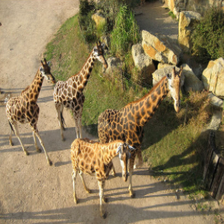

In [35]:
image = load_image('giraffe.png')
image

In [36]:
generate_caption(image, encoder, decoder, vocab)

'<start> a group of giraffes standing next to each other .'

## Just for fun: try on any image (using your webcam)

In [37]:
# Might require pip install opencv-python
import cv2

def camera_grab(camera_id=0):
    """This function captures an image through the webcam of your laptop (if accessible)
    """
    camera = cv2.VideoCapture(camera_id)
    try:
        for i in range(10):
            snapshot_ok, image = camera.read()
        if not snapshot_ok:
            raise RuntimeError("Could not access camera")
    finally:
        camera.release()
    return image

(-0.5, 1279.5, 719.5, -0.5)

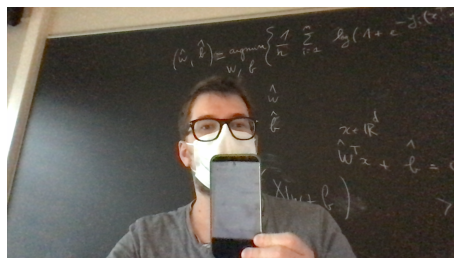

In [40]:
image = camera_grab()
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

In [41]:
# Write the image on disk
plt.imsave("webcam.jpg", cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Read again the image
image = load_image("webcam.jpg")

# And generate the caption
generate_caption(image, encoder, decoder, vocab)

'<start> a man holding a smart phone in front of a building .'